In [33]:
!sudo apt-get update
!sudo apt-get install -y libvips42

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1299 B]
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:3 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease    
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1419 kB]
Reading package lists... Done      
W: http://packages.cloud.google.com/apt/dists/gcsfuse-focal/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the D

Here I discovered my [Jar of Gold](https://histolab.readthedocs.io/en/latest/tissue_masks.html), for working with WSI images. I'll be able to clean up my data and turn it into mosaics

``!pip install --upgrade pip``

In [34]:
!pip install pyvips
!pip install --upgrade pip
!pip install histolab
!pip install large-image[all] --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels


In [35]:
%%capture 

from pathlib import Path
from PIL import Image

import time
import cv2
import os
import pyvips
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

from scipy.signal import find_peaks, savgol_filter

In [36]:
#It will help us clean the data

from histolab.filters.image_filters import (
   ApplyMaskImage,
   GreenPenFilter,
   Invert,
   OtsuThreshold,
   RgbToGrayscale,
)
from histolab.filters.morphological_filters import RemoveSmallHoles, RemoveSmallObjects
from histolab.masks import TissueMask
from histolab.slide import Slide

In [37]:
#It will help us title the data

from histolab.tiler import ScoreTiler
from histolab.scorer import NucleiScorer

## Import data

- Information about WSI images:
    - Whole Slide Imaging (WSI) is a digital imaging technique used in pathology and histology. It involves scanning entire microscope slides at high resolution to create digital representations of tissue samples. These digital slides can be viewed and analyzed on a computer, facilitating remote consultation, research, and precise diagnostic assessments in fields like medicine and life sciences. WSI is transforming traditional microscopy by enabling comprehensive digital analysis of large tissue specimens.
    
    <!DOCTYPE html>
<html>
<head>
    <style>
        body {
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            margin: 0;
        }

        img {
            max-width: 100%;
            max-height: 100%;
        }
    </style>
</head>
<body>
    <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0169260719302111-gr1.jpg" alt="Imagem Centralizada">
</body>
</html>


- WSI images are known for their significant size due to high resolution and the complete scanning of entire microscope slides. So, the images from ``train_image`` are too large. Looking around the discussion forums, this means that we have a problem with the notebook's memory. How can we solve this? Looking around the discussion forums, this means that we have a problem with the notebook's memory. How can we solve this? Not only for the data import, which seems complicated, but also when we run a model. The tip is obvious: improve the memory using the GPU.

In [38]:
path = Path('/kaggle/input')

In [39]:
train_set = pd.read_csv(path / 'UBC-OCEAN' / 'train.csv')
test_set = pd.read_csv(path / 'UBC-OCEAN' / 'test.csv')

In [40]:
train_set.head(10)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
5,431,HGSC,39991,40943,False
6,706,HGSC,75606,25965,False
7,970,HGSC,32131,18935,False
8,1020,HGSC,36585,33751,False
9,1080,HGSC,31336,23200,False


In [41]:
test_set.head() 

,image_id,image_width,image_height
0,41,28469,16987


In [42]:
train_set.shape, test_set.shape

((538, 5), (1, 3))

For this type of data, very large images, the following error can occur both when opening (and, I suppose, when operating): `DecompressionBombError: Image size (2080548450 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack`. Trying to compress these images could trigger a problem of losing important features in the modeling, so let's not alter the files. Let's not mess with the quiet ones. Let's check your ``thumbnails``, just for visualization. 


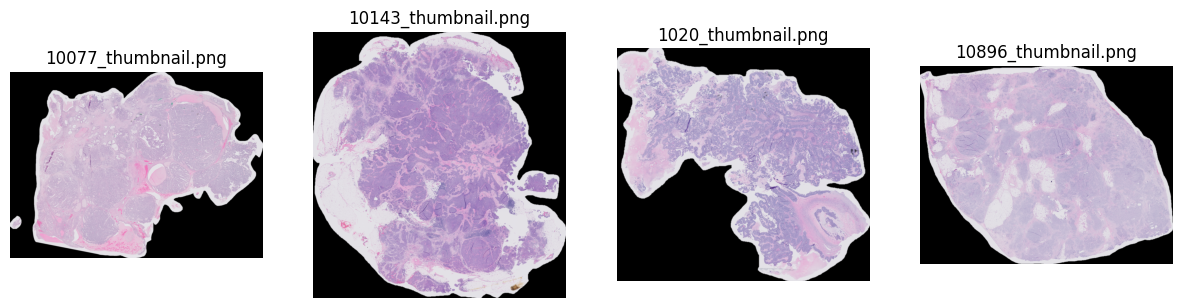

In [43]:
train_path_thumb = path / 'UBC-OCEAN' / 'train_thumbnails'

imagelist = ["10077_thumbnail.png", "10143_thumbnail.png", "1020_thumbnail.png", "10896_thumbnail.png"]
images = list()

for i in imagelist:
    img = Image.open(train_path_thumb / i)
    images.append(img)

num_cols = len(images)

# Create subplots
fig, axs = plt.subplots(1, num_cols, figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axis
    axs[i].set_title(imagelist[i])  # Title

plt.show()

## Exploratory data analysis

- The central idea of the work, therefore, is to fragment these large images into smaller pieces, tiles, and thus be able to operationalize this data
- To explore de train set, we must to known the data attributes:
    - ``image_id`` - A unique ID code for each image.
    - ``label`` - The target class. One of these subtypes of ovarian cancer: ``CC``, ``EC``, ``HGSC``, ``LGSC``, ``MC``, ``Other``. The ``Other`` class is not present in the training set; identifying outliers is one of the challenges of this competition. Only available for the train set.
    - ``image_width`` - The image width in pixels.
    - ``image_height`` - The image height in pixels.
    - ``is_tma`` - True if the slide is a tissue microarray. Only available for the train set.
    
    
- So, knowing that there is an Others to be discovered, we must first relate each file in the ``train_images`` directory to the ``train_set`` by its respective ``image_id``. However, right off the bat, we see that this relationship is neither simple nor obvious. Some values can be related, such as the image ``12522``, but with the ``image_id`` number 4, there is no relationship. 

In [44]:
train_path = path / 'UBC-OCEAN' / 'train_images'

n_images_train = list(train_path.iterdir())
row, _ = train_set.shape

if len(n_images_train) == row:
    print(f'Apparently all the images have a classification in the train_set table, which will make finding outliers more difficult than I thought.')

Apparently all the images have a classification in the train_set table, which will make finding outliers more difficult than I thought.


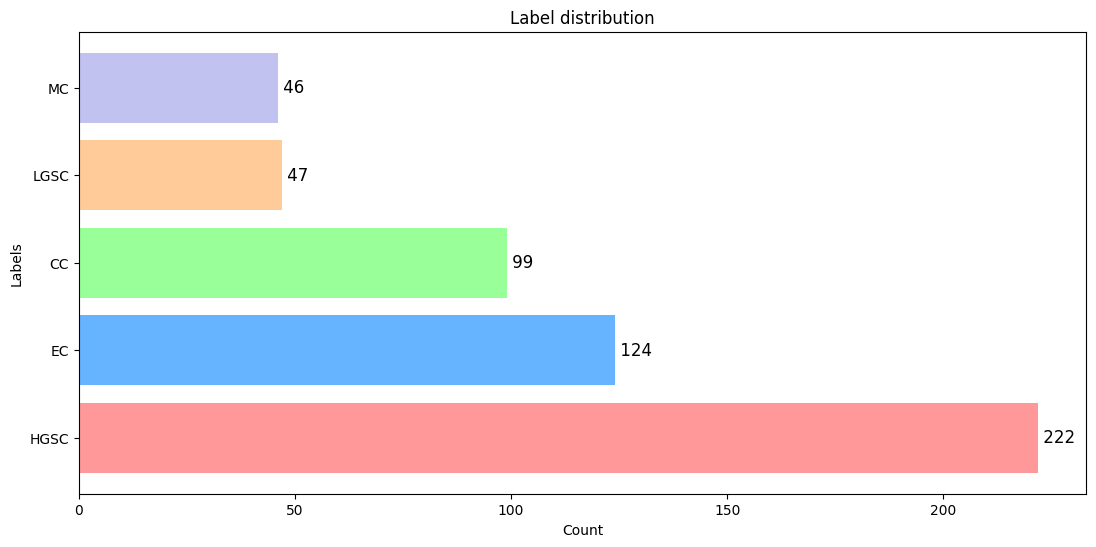

In [45]:
label_counts = train_set['label'].value_counts()
labels = label_counts.index
counts = label_counts.values

# Personal colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

fig, ax = plt.subplots(figsize=(13, 6))
ax.barh(labels, counts, color=colors)

# Adiciona rótulos
for i in range(len(labels)):
    ax.text(counts[i], labels[i], f" {counts[i]}", va='center', fontsize=12, color='black')

plt.title("Label distribution")
plt.xlabel("Count")
plt.ylabel("Labels")
plt.show()

#One possibility is that there is more than one type of uterine cancer in a photograph?


- Acoording Acharya et al. (2005), yes, it is possible for more than one cancer to take over the uterus, although this is classified as "rare cases". 

References:
    [Acharya, Sheetal, et al. "Rare uterine cancers." The lancet oncology 6.12 (2005): 961-971.](https://www.thelancet.com/journals/lanonc/article/PIIS1470204505704630/fulltext)


In [46]:
def create_image_dir(image_id, path):
    return f"{path}/{image_id}.png"

In [47]:
# Add'image_train_dir'col
train_set['image_train_dir'] = train_set['image_id'].map(lambda x: create_image_dir(x, path=train_path))

Note that in ``train_thumbnnails``are ``513`` files, while in ``train_images`` are ``538`` files. Let's always assume the position of the paranoid. Are these the WICs that contain the outliers? Are those the ones? Are they? Are they? Where are you outliers?

In [48]:
thumb_path = path / 'UBC-OCEAN' / 'train_thumbnails' 

train_files = set(int(file.stem) for file in train_path.glob('*.png'))
train_thumbnails_files = set(int(file.stem.split('_')[0]) for file in thumb_path.glob('*_thumbnail.png'))

files_not_in_thumb = train_files - train_thumbnails_files

print("Unique files in train_images that are not in train_thumbnails:")
for file in files_not_in_thumb:
    print(f"{file}.png")
print()
print(f'Count: {len(files_not_in_thumb)}')

Unique files in train_images that are not in train_thumbnails:
13568.png
37385.png
53655.png
41368.png
29084.png
21020.png
40864.png
4134.png
36783.png
44603.png
47035.png
36302.png
8280.png
91.png
48734.png
57696.png
61797.png
17637.png
36583.png
42857.png
31594.png
35565.png
9200.png
41586.png
50932.png

Count: 25


In [49]:
#Add image_train_thumbnails in colun

def create_image_thumbnails_dir(image_id, files_not_in_thumb):
    image_number = int(''.join(filter(str.isdigit, image_id)))
    if image_number in files_not_in_thumb:
        return np.nan
    return image_id.replace('.png', '_thumbnail.png').replace('train_images', 'train_thumbnails')

train_set['image_train_thumbnails'] = train_set['image_train_dir'].apply(create_image_thumbnails_dir, args=(files_not_in_thumb,))

In [50]:
train_set['image_train_thumbnails'].isnull().sum()

25

In [51]:
train_set['image_pixels'] = train_set['image_width'] * train_set['image_height']

In [52]:
train_set

,image_id,label,image_width,image_height,is_tma,image_train_dir,image_train_thumbnails,image_pixels
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_images/4.png,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...,475890280
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_images/66.png,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...,2355337845
2,91,HGSC,3388,3388,True,/kaggle/input/UBC-OCEAN/train_images/91.png,NaN,11478544
3,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_images/281.png,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...,657693405
4,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_images/286.png,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...,1116864080
...,...,...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_images/65022.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...,2490344625
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_images/65094.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...,2481293360
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_images/65300.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...,2086377580
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_images/65371.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...,1778631800


## Cleaning Data 🧹

### Crop duplicate WSI images

Whole Slide Images (WSIs) are high-res pathology images often used in research. They can be huge due to their high quality.

Duplicate regions in WSIs happen because of folds, multiple sections, errors, or even intentional duplications.

It's crucial to address these duplicates in computational pathology to avoid bias in quantitative analysis and machine learning training.

- Thanks for [Doopie](https://www.kaggle.com/code/dhinkris/crop-duplicate-wsi-images)

In [53]:
class ImageProcessing:

    def smooth_signal(self, signal, window_length=5, polyorder=3):
        return savgol_filter(signal, window_length, polyorder)

    def detect_peaks(self, signal, prominence=150):
        peaks, _ = find_peaks(signal, prominence=prominence)
        return peaks

    def crop_image(self, input_image):
        image = cv2.imread(input_image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cropped_images = []
        coordinates = []
        for i, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            cropped_image = image[y:y+h, x:x+w]
            if np.sum(np.array(cropped_image)) > 100000:
                cropped_images.append(cropped_image)
                coordinates.append((x, y, w, h))
        return cropped_images, coordinates

    def scale_signal(self, signal, min_range, max_range):
        min_value = np.min(signal)
        max_value = np.max(signal)
        scaled_signal = min_range + (signal - min_value) / (max_value - min_value) * (max_range - min_range)
        return scaled_signal

    def process_image(self, image_path):
        if image_path is not np.nan:
            image = Image.open(image_path)
            smoothed_signal = self.smooth_signal(np.mean(np.array(image)[:, :, 0], axis=0))
            peaks = self.detect_peaks(smoothed_signal)
            if len(peaks) > 1:
                images, coordinates = self.crop_image(image_path)
                return images, image, smoothed_signal, coordinates
                
    def plot_images(self, images, image, smoothed_signal, dataset, i):
        fig, axarr = plt.subplots(1, 2+len(images), figsize=(3*(2+len(images)), 3))
        fig.suptitle("Image ID: {}, Label: {}".format(dataset['image_id'][i], dataset['label'][i]))
        for i, ax in enumerate(axarr.ravel()):
            if i == 0:
                ax.imshow(np.array(image))
                ax.axis('off')
                ax.set_title("Original Image")
            elif i == 1:
                _range = axarr[0].get_ylim()
                ax.plot(self.scale_signal(smoothed_signal, _range[1], _range[0]))
                ax.axis('off')
                ax.set_title("1D Signal of Original Image")
            else:
                ax.imshow(np.array(images, dtype='object')[i-2])
                ax.axis('off')
                ax.set_title("Cropped Image {}".format(i-2))
        plt.tight_layout()
        plt.show()

- Obviously I'm not going to plot the processing of hundreds of duplicate images, but it's worth checking out a small sample

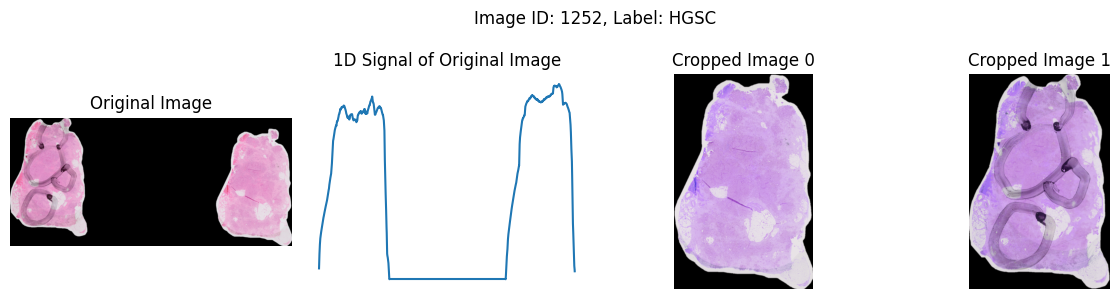

In [54]:
image_processor = ImageProcessing()
images, image, smoothed_signal, coordinates = image_processor.process_image(train_set['image_train_thumbnails'][11])
image_processor.plot_images(images, image, smoothed_signal, train_set, 11)

In [55]:
image_processor = ImageProcessing()

id_coordinates = dict()

for i in train_set.index:
    args = image_processor.process_image(train_set['image_train_thumbnails'][i])
    if args is not None:
        images, *_, coordinates = args
        id_coordinates[train_set['image_id'][i]] = coordinates

del images 

data_df = pd.DataFrame(id_coordinates.items(), columns=['image_id', 'coordinates'])

train_set['to_crop'] = train_set['image_id'].isin(data_df['image_id'])
train_set['area_thumbnail'] = train_set['image_id'].map(data_df.set_index('image_id')['coordinates'])
train_set['slices'] = [int(len(area)) if area is not np.nan else np.nan for area in train_set['area']]

del data_df

In [57]:
rows = len(train_set)
true_slices = train_set['slices'].notnull().sum()
n_slices = np.nansum(train_set['slices'])
dimension = rows + (n_slices - true_slices)
print(f'The new train_set dimension should be {dimension}')

The new train_set dimension should be 763.0


- Cropping information is exclusive to thumbnails. However, if we find out the height and width of these thumbnails, we can also find out the pyramidal proportion of each respective thumbnail in relation to its slide training image. And finally, find out the correct proportion to crop the training slides. 

In [58]:
def get_image_size(caminho_imagem):
    imagem = Image.open(caminho_imagem)
    w, h = imagem.size
    p = w * h
    return p, w, h

In [112]:
def pixel_area(coord):
    width = coord[2] - coord[0]
    heigth = coord[3] - coord[1]
    return (abs(width * heigth))

def calculate_area(row, scale):
    areas = list()
    for coord in row:
        areas.append(pixel_area(coord) * scale)
    return areas

In [114]:
for i in range(len(train_set)):
    if not pd.isna(train_set['image_train_thumbnails'][i]):
        p, w, h = get_image_size(train_set['image_train_thumbnails'][i])
        
        train_set.loc[i, 'thumbnail_pixel'] = p
        train_set.loc[i, 'thumbnail_width'] = w
        train_set.loc[i, 'thumbnail_height'] = h
        train_set.loc[i, 'scale'] = train_set['image_pixels'][i] / p

    if train_set['area'][i] is not np.nan:
        train_set.loc[i, 'calculate_areas'] = str(calculate_area(train_set['area'][i], train_set['scale'][i]))

In [116]:
train_set

,image_id,label,image_width,image_height,is_tma,image_train_dir,image_train_thumbnails,image_pixels,to_crop,area,slices,thumbnail_pixel,thumbnail_width,thumbnail_height,scale,calculate_areas_thumbnails,calculate_areas
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_images/4.png,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...,475890280,False,NaN,NaN,7569000.0,3000.0,2523.0,62.873600,NaN,NaN
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_images/66.png,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...,2355337845,False,NaN,NaN,8874000.0,3000.0,2958.0,265.420086,NaN,NaN
2,91,HGSC,3388,3388,True,/kaggle/input/UBC-OCEAN/train_images/91.png,NaN,11478544,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_images/281.png,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...,657693405,True,"[(1949, 13, 1051, 1059), (0, 0, 1028, 1102)]",2.0,3306000.0,3000.0,1102.0,198.939324,"[186865298.5068784, 225369606.78]","[186865298.5068784, 225369606.78]"
4,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_images/286.png,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...,1116864080,False,NaN,NaN,7260000.0,3000.0,2420.0,153.838028,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_images/65022.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...,2490344625,True,"[(1284, 12, 1716, 2300), (0, 0, 1241, 2624)]",2.0,7872000.0,3000.0,2624.0,316.354754,"[312690100.7195122, 1030172559.875]","[312690100.7195122, 1030172559.875]"
534,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_images/65094.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...,2481293360,False,NaN,NaN,7371000.0,3000.0,2457.0,336.629136,NaN,NaN
535,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_images/65300.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...,2086377580,True,"[(1869, 103, 1131, 984), (0, 0, 1172, 984)]",2.0,3261000.0,3000.0,1087.0,639.796866,"[415981846.7369641, 737844456.1115731]","[415981846.7369641, 737844456.1115731]"
536,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_images/65371.png,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...,1778631800,False,NaN,NaN,8841000.0,3000.0,2947.0,201.179934,NaN,NaN


- Cleaning WSI images is of utmost importance when preparing data for analysis by Convolutional Neural Networks (CNNs). Removing holes, stains, and unwanted artifacts is essential to ensure that the CNN produces accurate and reliable results. This cleaning enhances data quality and the neural network's ability to identify relevant patterns in tissues or microscopic samples. By eliminating holes or non-informative areas, the CNN can focus on features of interest, such as cellular structures or disease patterns. This not only speeds up the analysis process but also reduces the risk of misinterpretations due to visual interferences.

In [ ]:
image_path = train_set['image_train_thumbnails'][11]

img = plt.imread(image_path)

x1, x2, y1, y2 = 500, 700, 500, 700
zoomed_in = img[y1:y2, x1:x2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title('Image ID: 1252,  Label: HGSC')
ax2.imshow(zoomed_in)

ax2.set_title('Zoom')
ax2.set_xlim(0, x2 - x1)
ax2.set_ylim(y2 - y1, 0)

plt.show()

In [ ]:
img = plt.imread(train_set['image_train_thumbnails'][4])
plt.imshow(img)
plt.show()

In [ ]:
image = pyvips.Image.new_from_file('/kaggle/input/UBC-OCEAN/train_images/10077.png')
image.tiffsave(f"10077.tif", Q=100, tile=True, pyramid=True)

In [ ]:
input_path = '/kaggle/working/10077.tif'
output_path = '/kaggle/working/'

ovarian_slide = Slide(input_path, processed_path=output_path, use_largeimage = True)

In [ ]:
ovarian_slide.shape

In [ ]:
print(f"Slide name: {ovarian_slide.name}")
print(f"Levels: {ovarian_slide.levels}")
#print(f"Dimensions at level 0: {ovarian_slide.dimensions}")
#print(f"Dimensions at level 1: {ovarian_slide.level_dimensions(level=1)}")
#print(f"Dimensions at level 2: {ovarian_slide.level_dimensions(level=2)}")

In [ ]:
from histolab.tiler import GridTiler

In [ ]:
grid_tiles_extractor = GridTiler(
   tile_size=(512, 512),
   level=0,
   check_tissue=True, # default
   pixel_overlap=0, # default
   prefix="grid/", # save tiles in the "grid" subdirectory of slide's processed_path
   suffix=".tif" # default
)

grid_tiles_extractor.locate_tiles(
    slide=ovarian_slide,
    scale_factor=64,
    alpha=64,
    outline="#046C4C",
)


In [ ]:
grid_tiles_extractor.extract(ovarian_slide)

In [ ]:
scored_tiles_extractor = ScoreTiler(
    scorer = NucleiScorer(),
    tile_size=(512, 512),
    n_tiles=100,
    level=0,
    check_tissue=True,
    tissue_percent=80.0,
    pixel_overlap=0, # default
    prefix="scored/", # save tiles in the "scored" subdirectory of slide's processed_path
    suffix=".png" # default
)

In [ ]:
grid_tiles_extractor.locate_tiles(slide=ovarian_slide)

The poor efficiency of image cleaning is due to the low resolution of the mosaic. However, it will obviously be effective on real training images.

In [ ]:
tile_size = 500

wsi_path = '/kaggle/input/UBC-OCEAN/train_images/10077.png'

pathml_slide = Slide(wsi_path, level=0).setTileProperties(tileSize=tile_size)

pathml_slide.detectTissue() 
pathml_slide.detectForeground()

## Let's put our new toy to the test.